<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Exercise Set 2, Solutions to Exercise 1 - Regression Neural Network

This is a copy of notebook ```nn-regr.ipynb``` for solving the following exercises:

  0. Run all cells.  
   
  1. Replace the sigmoid activation function with the **ReLU** function and observe how the shape of the predicted curve changes. *Revert back* afterwards to the *sigmoid* activation function.
   
  2. **Shift** the simulated data on the **x**-axis by **+50**.  
    
    2.1. **For the mathematically inclined:** Let $x' := x + 50$. Show or argue that it theoretically does not matter if you shift (use input $x'$) or not (use $x$):  *For any neural net $f(x)$ there is a neural net $f'(x')$ such that $f'(x') = f(x)$*. You may assume that $n=1$.
    
    2.2. Go to ADD YOUR CODE HERE and follow the instructions. Run all cells. What happens to the goodness of the fit? Do you have an explanation? Tip: Compute the net activations of the first layer manually right before training starts.

### **Answer to 2.1.:**
<img style="float:left" src="reparametrize.png" width="200px" />

Let $z_j$ be any particular net activation of the first hidden layer. We omit the superscripts that indicate the layers, here.

$$\begin{align*}
z_j &= \theta_{j,0} + \theta_{j,1} \cdot x\\
&=  \theta_{j,0} + \theta_{j,1} \cdot (x' - 50)\\
&= (\theta_{j,0} - 50 \cdot \theta_{j,1}) + \theta_{j,1} \cdot x'\\
&= \theta'_{j,0} + \theta_{j,1} \cdot x'
\end{align*}
$$

if one defines the bias term for the $j$-th unit of the first hidden layer of $f'$ as $\theta'_{j,0}:=\theta_{j,0} - 50 \cdot \theta_{j,1}$. Therefore, the activations of the first hidden layer are equal in the two networks and the remaining layers can be identical for the two networks to compute identical functions.

## Generate an Artificial Dataset

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense

tf.keras.backend.set_floatx('float64') # floating point precision 64 bits

In [2]:
def f(x):
    '''A simple one-dimensional function with a few extrema'''
    return np.sin(15 * x) + 9 * x - 9 * x**2

#### Simulate $(x, y)$ pairs as artificial data set

In [3]:
np.random.seed(1)
m = 100 # number of data points (examples)
x = np.linspace(0, 1, m) # equidistant in [0,1] (both boundaries included)
y_theoretical = f(x)     # the points on the curve
# ADD YOUR CODE HERE to shift x by +50, 1 line
x = x + 50
# YOUR CODE ENDS
sigma = 0.1
y = y_theoretical + sigma * np.random.randn(m) # observations have noise (normal with mean 0 and variance sigma^2 = 0.01)

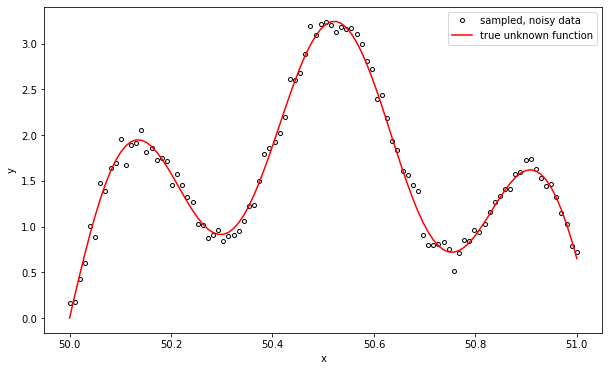

In [4]:
def plot_curve():
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(x, y, 'ko', fillstyle = 'none', markersize = 4, label = "sampled, noisy data") # ko: blac(k) circle
    ax.plot(x, y_theoretical, 'r', label = "true unknown function")
    plt.xlabel("x")
    plt.ylabel("y")
    return ax

ax = plot_curve()
ax.legend();

## Create Neural Network Model  
We will use [```tf.keras```](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras), a high-level approach to neural network design and learning. The NN shall have 2 hidden layers with 8 neurons each. As activation functions we chose the logistic sigmoid function $\sigma$.

<img src="nn8-8.png" alt="network architecture" width="500"/>

In [5]:
tf.random.set_seed(13032021) # so we all get the same pseudorandom results

# a neural network is a stack of layers, in keras called "Sequential" model
model = tf.keras.models.Sequential() # so far the stack is empty, 0 layers

# add neural network layers one by one
# Dense is a fully connected layer, parametrized by a matrix of shape (input_units, output_units).
# The first number given in Dense is the number of output units, the number of input units is implicit.
# By default use_bias=True which adds output_units parameters for each layer
# REPLACE THE ACTIVATION FUNCTION HERE with tf.nn.relu
model.add(Dense(8, activation = tf.nn.sigmoid, input_dim = 1)) # input dimension only required for first layer
model.add(Dense(8, activation = tf.nn.sigmoid))
# YOUR CHANGES END HERE
model.add(Dense(1))

model.summary()     # summarizes layers and parameters
Theta = model.get_weights() # a look under the 'hood' for teaching purposes
print(Theta)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
[array([[-0.67375132, -0.38001007, -0.55320019, -0.29227385, -0.01847462,
         0.12705687,  0.04353513,  0.51694476]]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([[ 0.16621145, -0.51258874, -0.00674431, -0.19242605, -0.53663484,
        -0.58747439, -0.0134006 , -0.57761667],
       [-0.45086475, -0.05830532,  0.1266707 ,  0.53309134,  0.22778828,
        -0.42107537, -0.4507837

## Explanation, why the training with the x-shift by +50 fails
To see this we will manually compute the **activations of the first layer right after the random initialization** of the model parameters.

In [6]:
Theta0 = Theta[0] # weights of the first layer, shape =(1,8)
bias0 = Theta[1] # biases of the first layer, shape = (8,) 

# compute net activations of first layer
z1 = np.matmul(x.reshape([-1,1]), Theta0) + bias0


def sigmoid(z):
    """The logistic sigmoid function"""
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(x):
    """ The derivative of sigmoid"""
    return sigmoid(x) * (1-sigmoid(x))


print("z1\n", z1[0:5].round(3)) # print the net activations of the first layer for the first 5 examples
print("\na1\n", sigmoid(z1[0:5])) # print the net activations of the first layer for the first 10 examples
print("\nderivatives used in backprop:\n", sigmoid_deriv(z1[0:5])) # print the net activations of the first layer for the first 10 examples


z1
 [[-33.688 -19.001 -27.66  -14.614  -0.924   6.353   2.177  25.847]
 [-33.694 -19.004 -27.666 -14.617  -0.924   6.354   2.177  25.852]
 [-33.701 -19.008 -27.671 -14.62   -0.924   6.355   2.178  25.858]
 [-33.708 -19.012 -27.677 -14.623  -0.924   6.357   2.178  25.863]
 [-33.715 -19.016 -27.682 -14.626  -0.924   6.358   2.179  25.868]]

a1
 [[2.34248066e-15 5.59997509e-09 9.71427844e-13 4.50146505e-07
  2.84198273e-01 9.98261241e-01 8.98142710e-01 1.00000000e+00]
 [2.32659287e-15 5.57852086e-09 9.66014759e-13 4.48819516e-07
  2.84160312e-01 9.98263468e-01 8.98182932e-01 1.00000000e+00]
 [2.31081284e-15 5.55714884e-09 9.60631837e-13 4.47496438e-07
  2.84122354e-01 9.98265691e-01 8.98223140e-01 1.00000000e+00]
 [2.29513983e-15 5.53585869e-09 9.55278910e-13 4.46177260e-07
  2.84084399e-01 9.98267912e-01 8.98263334e-01 1.00000000e+00]
 [2.27957313e-15 5.51465011e-09 9.49955812e-13 4.44861972e-07
  2.84046448e-01 9.98270129e-01 8.98303514e-01 1.00000000e+00]]

derivatives used in backprop

**Observation:** Almost all net activations of the first layer have a large absolute value. For large absolut value the logistic sigmoid function has a derivative very close to 0:

<img src="activ-sigma.png" alt="sigmoid function" width="300"/>

Therefore, any small change to any weight of an edge of the first layer that goes into such a unit is very close to 0 or even vanishes numerically.

### Compile the model

In [7]:
# define the loss, optimization algorithm and prepare the model for gradient computation 
opti = tf.keras.optimizers.Adam(learning_rate = 0.05) # Adam is a popular method for stochastic gradient descent
model.compile(optimizer = opti, loss = 'mse') # mean squared error

### Train the parameters (learning)

In [8]:
# execute the actual training 
history = model.fit(x, y, epochs=3000, verbose=0) # takes ~20s
# verbose = 1,2 gives more output

### Examine the learning progress

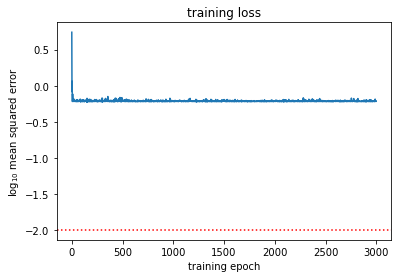

In [9]:
plt.plot(np.log10(history.history["loss"])); # one mse value per epoch
plt.title("training loss")
plt.xlabel("training epoch")
plt.ylabel(r"$\log_{10}$ mean squared error");
plt.axhline(y = np.log10(sigma**2), color = "red", linestyle = ":");

Observe that with our choice for the measurement noise the theoretical optimum for the mean squared error *on new data* is $10^{-2}$ (red dotted line).
### Use the model for predictions

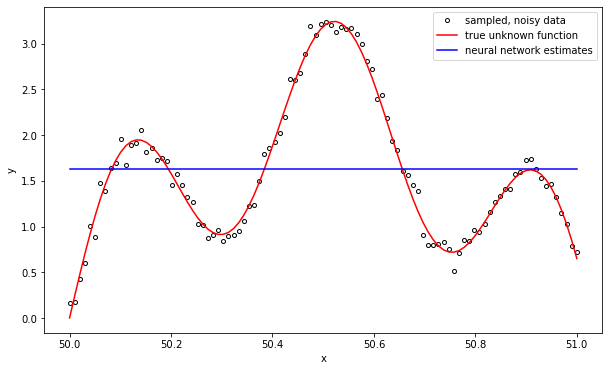

In [10]:
x_input = x.reshape((-1, 1)) # make x a matrix (with 1 column) as expected by predict
y_pred = model.predict(x_input)

ax = plot_curve()
ax.plot(x, y_pred, 'b', label = "neural network estimates") # (b)lue
ax.legend();